***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com 

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)

**Outline:**<br/>
**1️⃣ Importing the dataset**<br/>
**2️⃣ Convert the images into array & masks to binary**<br/>
**3️⃣ RGB to gray**<br/>
**4️⃣ [Image Resizing](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize)**<br/>
**6️⃣ Mask-Based Image Cropping**<br/>
**7️⃣ U-Net Architectur**<br/>

`Image classification` assigns <font color =#f57207>*a single label to an entire image*</font>, while `segmentation` goes a step further by <font color =#f57207>*labeling each pixel or group of pixels*</font>, effectively dividing the image into meaningful components. This enables more detailed analysis and supports applications like object detection, medical imaging, and autonomous driving, where identifying specific parts of an image is essential.

**Image Segmentation Types:**<br/>
<font color =#38f109><b>Semantic Segmentation:</b></font><br/>
▪ Assigns each pixel to a specific class<br/>
▪ Doesn't distinguish between instances of same class<br/>
▪ Example: All cars are labeled as "car" class<br/>

<font color =#38f109><b>Instance Segmentation:</b></font><br/>
▪ Detects and segments individual objects<br/>
▪ Distinguishes between instances of same class<br/>
▪ Example: Each car gets unique label (car1, car2)<br/>

<font color =#38f109><b>Panoptic Segmentation:</b></font><br/>
▪ Combines semantic and instance segmentation<br/>
▪ Segments both countable objects and background<br/>
▪ Example: Cars as instances + road/sky as semantic<br/>

<font color =#38f109><b>Binary Segmentation:</b></font><br/>
▪ Segments image into foreground and background<br/>
▪ Only two classes (0 or 1)<br/>
▪ Example: Object vs background<br/>

<font color =#38f109><b>Real-time Segmentation:</b></font><br/>
▪ Fast processing for video/streaming<br/>
▪ Often trades accuracy for speed<br/>
▪ Example: Self-driving car vision systems<br/>

**Segmentation methods:**<br/>
▪ <font color =#f17909><b>Manual annotation</b></font> involves marking image boundaries or regions of interest. Though reliable, it is time-consuming, labor-intensive, prone to errors, and unsuitable for large datasets or complex tasks due to consistency challenges.<br/>

▪ <font color =#f17909><b>Pixel-wise classification</b></font> independently classifies each pixel using algorithms like decision trees, SVMs, or random forests. However, it often fails to capture global context, spatial relationships, and accurate object boundaries, leading to segmentation issues.<br/>

▪ <font color =#f17909><b>U-Net's</b></font> architecture features a contracting path and an expansive path. The contracting path, similar to feedforward layers in other CNNs, uses encoder layers to reduce spatial resolution while capturing contextual information. The expansive path uses decoder layers to upsample feature maps and decode the data, aided by skip connections from the contracting path to preserve spatial details. This combination enables accurate feature localization and segmentation map generation.<br/>

**UNET** was developed to address the inefficiencies and inaccuracies of traditional image segmentation methods.<br/>
▪ <font color =#38f109><b>End-to-End Learning:</b></font><br/>
UNET employs an end-to-end learning approach, enabling it to segment images directly from input-output pairs without requiring user annotations. By training on a large, labeled dataset, UNET automatically extracts essential features and delivers precise segmentation, eliminating the need for time-consuming manual labeling. <br/>

▪ <font color =#38f109><b>Fully Convolutional Architecture:</b></font> <br/>
UNET utilizes a fully convolutional architecture, consisting solely of convolutional layers without any fully connected layers. This design allows UNET to process input images of any size, enhancing its versatility and adaptability for diverse segmentation tasks and varying input dimensions.<br/>

▪ <font color =#38f109><b>U-shaped Architecture with Skip Connections:</b></font><br/> 
The network's architecture features encoding and decoding paths for local and global context, with skip connections preserving key information for precise segmentation.<br/>

▪ <font color =#38f109><b>Contextual Information and Localisation:</b></font> <br/>
Skip connections in UNET merge multi-scale features, enhancing context absorption, detail capture, and improving segmentation accuracy with precise object boundaries. <br/>

▪ <font color =#38f109><b>Data Augmentation and Regularization:</b></font> <br/>
UNET enhances resilience and generalization by using data augmentation, like rotations, flips, scaling, and deformations, to diversify training data, and regularization techniques, such as dropout and batch normalization, to prevent overfitting. <br/>

**Key Elements of the UNET Framework:**<br/>
▪ <font color =#f17909><b>Contracting Path (Encoding Path):</b></font><br/> 
UNET's contracting path uses convolution and max pooling techniques to capture high-resolution, low-level features while reducing spatial dimensions. Each downsampling step doubles the number of feature channels, allowing for extracting features at various scales from the input image.<br/>

▪ <font color =#f17909><b>Expanding Path (Decoding Path):</b></font><br/> 
Transposed convolutions, or deconvolutions, upsample feature maps in the UNET expansion path to reconstruct a detailed segmentation map. This technique restores the features to match the resolution of the input image, ensuring precise alignment.<br/>

▪ <font color =#f17909><b>Bottleneck (Bottom)</b></font><br/>
Bridge between contracting and expansive paths. Has the highest number of feature channels.<br/>

▪ <font color =#f17909><b>Skip Connections:</b></font><br/> 
Skip connections in UNET link encoding and decoding layers, preserving spatial details and enhancing segmentation by merging features from earlier layers. It concatenates the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output.<br/>

▪ <font color =#f17909><b>Fully Convolutional Layers:</b></font><br/> 
UNET uses convolutional layers, avoiding fully connected ones, allowing it to process images of any size while retaining spatial information for versatile segmentation tasks. <br/>

▪ <font color =#f17909><b>Final Layer:</b></font><br>
1x1 convolution to map feature vector to desired number of classes. Output is a pixel-wise segmentation map.<br/>

▪ <font color =#f17909><b>Dice Coefficient Loss:</b></font><br/>
The Dice coefficient measures overlap between predicted and true segmentation masks, while Dice loss (1 - Dice coefficient) minimizes as alignment improves. It's particularly effective for unbalanced datasets, encouraging accurate separation of foreground and background by penalizing false positives and negatives. <br/>

▪ <font color =#f17909><b>Cross-Entropy Loss:</b></font> <br/>
It is used in image segmentation to measure dissimilarity between predicted class probabilities and ground truth labels. It treats each pixel as an independent classification problem, encouraging high probabilities for correct classes and penalizing deviations. This method works well for balanced foreground/background classes or multi-class segmentation tasks. <br/>

**Common Evaluation Metrics for Image Segmentation:**<br/>
<font color =#09f1ab><b>Intersection over Union (IoU):</b></font><br/>
▪ Measures overlap between predicted and ground truth masks<br/>
▪ Formula: (Area of Intersection) / (Area of Union)<br/>
▪ Range: 0 (no overlap) to 1 (perfect overlap)<br/>
▪ Widely used for object detection and segmentation<br/>

<font color =#09f1ab><b>Dice Coefficient / F1 Score:</b></font><br/>
▪ Similar to IoU but gives more weight to overlapping regionsv<br/>
▪ Formula: 2 * (Area of Intersection) / (Sum of both areas)<br/>
▪ Range: 0 to 1<br/>
▪ Popular in medical image segmentation<br/>

<font color =#09f1ab><b>Pixel Accuracy:</b></font><br/>
▪ Ratio of correctly classified pixels to total pixels<br/>
▪ Simple but can be misleading with class imbalance<br/>
▪ Formula: (True Positives + True Negatives) / Total Pixels<br/>

<font color =#09f1ab><b>Mean Pixel Accuracy:</b></font><br/>
▪ Average per-class pixel accuracy<br/>
▪ Better for imbalanced classes<br/>
▪ Calculated separately for each class then averaged<br/>

<font color =#09f1ab><b>Mean IoU (mIoU):</b></font><br/>
▪ Average IoU across all classes<br/>
▪ Standard metric for semantic segmentation<br/>
▪ Handles class imbalance well<br/>

<font color =#09f1ab><b>Boundary F1 Score:</b></font><br/>
▪ Focuses on segmentation boundaries<br/>
▪ Important for precise edge detection<br/>
▪ Useful when boundary accuracy is critical<br/>

<font color =#09f1ab><b>Precision and Recall:</b></font><br/>
▪ Precision: Accuracy of positive predictions<br/>
▪ Recall: Ability to find all positive instances<br/>
▪ Important for specific applications<br/>

**Comparison of U-Net with CNN and FCN:**<br/>
<font color =#f109b7><b>Traditional CNN vs U-Net:</b></font><br/>
**`Traditional CNN:`**<br/>
▪ Primarily designed for classification tasks<br/>
▪ Uses fully connected layers at the end<br/>
▪ Loses spatial information through pooling<br/>
▪ Output is a single class label<br/>
▪ Not suitable for pixel-wise segmentation<br/>

**`U-Net:`**<br/>
▪ Specifically designed for segmentation<br/>
▪ Fully convolutional architecture<br/>
▪ Preserves spatial information via skip connections<br/>
▪ Output has same resolution as input<br/>
▪ Pixel-wise segmentation prediction<br/>

<font color =#f109b7><b>FCN vs U-Net:</b></font><br/>
**`Fully Convolutional Network (FCN):`**<br/>
▪ First architecture for end-to-end segmentation<br/>
▪ Uses VGG/ResNet as encoder<br/>
▪ Simple upsampling in decoder<br/>
▪ Limited skip connections<br/>
▪ Lower resolution output possible<br/>

**`U-Net:`**<br/>
▪ Symmetric encoder-decoder structure<br/>
▪ Custom encoder design<br/>
▪ Sophisticated decoder with skip connections<br/>
▪ Multiple skip connections at each level<br/>
▪ Maintains high resolution details<br/>
▪ Better for medical image segmentation<br/>

<font color='#FF000e' size="4.8" face="Arial"><b>Importing libraries</b></font>

In [51]:
import pprint
import numpy as np
from colorama import Fore
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Activation, BatchNormalization

from Functions.image_processor import ImageProcessor
from Functions.filepath_extractor import FilePathExtractor

<font color=#070bee size="4.5" face="Arial"><b>1️⃣ Importing the dataset</b></font>

In [4]:
# ================================================ Inputs ======================================================
directory_path = "D:/Medical-Image-Processing/Data/Inputs"

# Create an instance of DirectoryReader with the directory path and file format
obj_inputs = FilePathExtractor(directory_path, format_type="tif")
img_filesname = obj_inputs.filesname         # List of filesname in the directory

pprint.pprint(["Image files:", img_filesname])

['Image files:',
 ['ytma10_010704_benign1_ccd.tif',
  'ytma10_010704_benign2_ccd.tif',
  'ytma10_010704_benign3_ccd.tif',
  'ytma10_010704_malignant1_ccd.tif',
  'ytma10_010704_malignant2_ccd.tif',
  'ytma10_010704_malignant3_ccd.tif',
  'ytma12_010804_benign1_ccd.tif',
  'ytma12_010804_benign2_ccd.tif',
  'ytma12_010804_benign3_ccd.tif',
  'ytma12_010804_malignant1_ccd.tif',
  'ytma12_010804_malignant2_ccd.tif',
  'ytma12_010804_malignant3_ccd.tif',
  'ytma23_022103_benign1_ccd.tif',
  'ytma23_022103_benign2_ccd.tif',
  'ytma23_022103_benign3_ccd.tif',
  'ytma23_022103_malignant1_ccd.tif',
  'ytma23_022103_malignant2_ccd.tif',
  'ytma23_022103_malignant3_ccd.tif',
  'ytma49_042003_benign1_ccd.tif',
  'ytma49_042003_benign2_ccd.tif',
  'ytma49_042003_benign3_ccd.tif',
  'ytma49_042003_malignant1_ccd.tif',
  'ytma49_042003_malignant2_ccd.tif',
  'ytma49_042003_malignant3_ccd.tif',
  'ytma49_042203_benign1_ccd.tif',
  'ytma49_042203_benign2_ccd.tif',
  'ytma49_042203_benign3_ccd.tif',
  

In [5]:
# ==================================================== Masks ===================================================
directory_path = "D:/Medical-Image-Processing/Data/Masks/"

# Create an instance of DirectoryReader with the directory path and file format
obj_masks = FilePathExtractor(directory_path, format_type="TIF")
mask_filesname = obj_masks.filesname      # List of filesname in the directory

pprint.pprint(["Mask files:", mask_filesname])

['Mask files:',
 ['ytma10_010704_benign1.TIF',
  'ytma10_010704_benign2.TIF',
  'ytma10_010704_benign3.TIF',
  'ytma10_010704_malignant1.TIF',
  'ytma10_010704_malignant2.TIF',
  'ytma10_010704_malignant3.TIF',
  'ytma12_010804_benign1.TIF',
  'ytma12_010804_benign2.TIF',
  'ytma12_010804_benign3.TIF',
  'ytma12_010804_malignant1.TIF',
  'ytma12_010804_malignant2.TIF',
  'ytma12_010804_malignant3.TIF',
  'ytma23_022103_benign1.TIF',
  'ytma23_022103_benign2.TIF',
  'ytma23_022103_benign3.TIF',
  'ytma23_022103_malignant1.TIF',
  'ytma23_022103_malignant2.TIF',
  'ytma23_022103_malignant3.TIF',
  'ytma49_042003_benign1.TIF',
  'ytma49_042003_benign2.TIF',
  'ytma49_042003_benign3.TIF',
  'ytma49_042003_malignant1.TIF',
  'ytma49_042003_malignant2.TIF',
  'ytma49_042003_malignant3.TIF',
  'ytma49_042203_benign1.TIF',
  'ytma49_042203_benign2.TIF',
  'ytma49_042203_benign3.TIF',
  'ytma49_042203_malignant1.TIF',
  'ytma49_042203_malignant2.TIF',
  'ytma49_042203_malignant3.TIF',
  'ytma49

In [14]:
# ============================================ Check of the Images =============================================
# Define the format type for input files (e.g., filenames ending with "_ccd.tif")
inputs_format_type = "_ccd.tif"

# Define the format type for mask files (e.g., filenames ending with ".TIF")
mask_format_type = ".TIF"

# Compare the base filenames (without extensions) of input files and mask files
# This line checks if the list of base filenames for input files matches the list of base filenames for mask files
[i.split(inputs_format_type)[0] for i in img_filesname] == [i.split(mask_format_type)[0] for i in mask_filesname]

True

<font color=#09eb14 size="4.5" face="Arial"><b> 2️⃣ Convert the images into array & masks to binary</b></font>

In [7]:
# ================================================ Inputs ======================================================
# Define the directory path where the input images are stored
directory_path = "D:/Medical-Image-Processing/Data/Inputs"

# Create an instance of the `ImageProcessor` class
obj = ImageProcessor()

# Use the `imgs_to_ndarray` method of the `ImageProcessor` object to load images from the directory
# The images are expected to be in "tif" format, and they are converted into a NumPy array
data = obj.read_images(directory_path, format_type="tif")

# Print the shape of the resulting NumPy array
# The `inputs.shape` attribute gives the dimensions of the array (e.g., number of images, height, width, channels)
print(Fore.GREEN + f"{data.shape = }")

data.shape = (58, 768, 896, 3)


In [8]:
# ============================================= Masks to binary ================================================
# Define the directory path where the mask images are stored
directory_path = "D:/Medical-Image-Processing/Data/Masks/"

# Use the `masks_to_boolean` method of the `ImageProcessor` object to convert mask images to boolean from the directory
# The masks are expected to be in "TIF" format
masks = obj.masks_to_binary(directory_path, format_type="TIF")

# Print the shape of the resulting NumPy array
print(Fore.GREEN + f"{masks.shape = }")

masks.shape = (58, 768, 896, 1)


<font color=#ffcc25 size="4.5" face="Arial"><b>3️⃣ Resizing</b></font>

In [96]:
data_resize = obj.resize_images(data, img_height_resized=256, img_width_resized=256)
masks_resize = obj.resize_images(masks, img_height_resized=256, img_width_resized=256)

# Print the shape of the resulting NumPy array
print(Fore.GREEN + f"{data_resize.shape = }")
print(Fore.BLUE + f"{masks_resize.shape = }")

data_resize.shape = (58, 256, 256, 3)
masks_resize.shape = (58, 256, 256, 1)


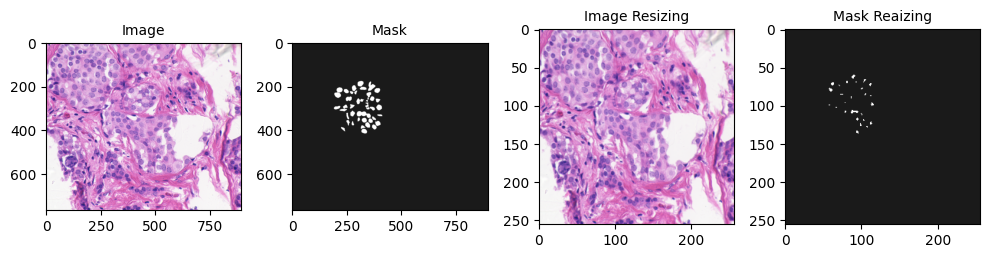

In [19]:
ind = 4 # Set the index of the image and mask to display
plt.figure(figsize=(10, 4))
plt.subplot(141); plt.imshow(data[ind]); plt.title('Image', fontsize=10)
plt.subplot(142); plt.imshow(masks[ind], cmap="gray", alpha=0.9); plt.title('Mask', fontsize=10)
plt.subplot(143); plt.imshow(data_resize[ind]); plt.title('Image Resizing', fontsize=10)
plt.subplot(144); plt.imshow(masks_resize[ind], cmap="gray", alpha=0.9); plt.title('Mask Reaizing', fontsize=10)
plt.tight_layout() # Adjust the layout to prevent overlap between subplots

<font color=#ee0caa size="4.5" face="Arial"><b>Prepare TensorFlow datasets for training, validation, and testing</b></font>

In [157]:
import pprint
import tensorflow as tf
from typing import Tuple, Union
from sklearn.model_selection import train_test_split

def prepare_dataset(
    data: Union[np.ndarray, tf.Tensor], 
    labels: Union[np.ndarray, tf.Tensor], 
    train_size: float = 0.8, 
    valid_size: float = 0.16, 
    batch_size: int = 16, 
    shuffle_train: bool = True, 
    shuffle_buffer_size: int = 1000
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    This function handles the complete pipeline from raw data to optimized TensorFlow Dataset objects,
    including data splitting, shuffling, batching, and prefetching for optimal performance.
    
    Args:
        data: Input features as either numpy array or TensorFlow tensor
               Shape should be (num_samples, ...features_dims)
        labels: Corresponding labels as either numpy array or TensorFlow tensor
                Shape should be (num_samples, ...label_dims)
        train_size: Proportion of total data to use for training (0.0 to 1.0)
        valid_size: Proportion of total data to use for validation (0.0 to 1.0)
        batch_size: Number of samples per training batch (positive integer)
        shuffle_train: Whether to shuffle training data (recommended for training)
        shuffle_buffer_size: Size of buffer used for shuffling (larger = better shuffling but more memory)
    
    Returns:
        A tuple containing three tf.data.Dataset objects in order:
        - train_dataset: Dataset for model training
        - valid_dataset: Dataset for validation during training
        - test_dataset: Dataset for final evaluation
    
    Raises:
        ValueError: If input sizes are invalid or data/labels have mismatched lengths
    """
    
    # ============================================ INPUT VALIDATION ============================================
    # Validate the split proportions make sense
    if train_size + valid_size > 1.0:
        raise ValueError("train_size + valid_size must not exceed 1.0 (test_size would be negative)")
    if train_size < valid_size:
        raise ValueError("Training set should typically be larger than validation set")

    # Convert TensorFlow tensors to numpy arrays for sklearn splitting
    if tf.is_tensor(data):
        data = data.numpy()
    if tf.is_tensor(labels):
        labels = labels.numpy()

    # Verify data and labels have compatible shapes
    if len(data) != len(labels):
        raise ValueError(f"Mismatched lengths: data has {len(data)} samples but labels has {len(labels)}")

    # ======================================== DATA SPLITTING ==================================================
    # First split separates test set from training+validation
    x_train_val, x_test, y_train_val, y_test = train_test_split(
        data,
        labels,
        train_size=train_size + valid_size,  # Combined size for train+val
        test_size=1.0 - (train_size + valid_size),  # Remainder for test
        random_state=24,  # Fixed seed for reproducibility
        # stratify=labels if len(set(labels)) > 1 else None  # Optional stratification
    )

    # Second split divides train+val into separate sets
    # Calculate relative proportion of validation within train+val subset
    valid_proportion = valid_size / (train_size + valid_size)
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train_val,
        y_train_val,
        train_size=1.0 - valid_proportion,  # Relative train size
        test_size=valid_proportion,          # Relative validation size
        random_state=24,  # Same seed for consistency
        # stratify=y_train_val if len(set(y_train_val)) > 1 else None
    )

    # ======================================= DATASET CREATION =================================================
    # Create TensorFlow Dataset objects with proper type casting
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_train, tf.float32),  # Convert features to float32
        tf.cast(y_train, tf.float32)    # Convert labels to float32
    ))
    valid_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_valid, tf.float32), 
        tf.cast(y_valid, tf.float32))
    )
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_test, tf.float32), 
        tf.cast(y_test, tf.float32))
    )
    
    # ====================================== DATASET OPTIMIZATION ==============================================
    # Shuffle training data if enabled (recommended for better training)
    if shuffle_train:
        train_dataset = train_dataset.shuffle(
            buffer_size=min(shuffle_buffer_size, len(x_train)),  # Don't exceed dataset size
            reshuffle_each_iteration=True  # Important for proper epoch training
        )
    
    # Batch all datasets for efficient processing
    train_dataset = train_dataset.batch(batch_size)
    valid_dataset = valid_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    
    # Prefetch data to overlap preprocessing and model execution
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)  # Let TensorFlow optimize buffer size
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    # ============================================ VERIFICATION OUTPUT =========================================
    print(f"Training set:   {x_train.shape} features, {y_train.shape} labels")
    print(f"Validation set: {x_valid.shape} features, {y_valid.shape} labels")
    print(f"Test set:       {x_test.shape} features, {y_test.shape} labels")
    print(f"\nBatch size:     {batch_size}")
    print(f"Training shuffle: {'enabled' if shuffle_train else 'disabled'}")
    print("\t")
    pprint.pprint(train_dataset.element_spec, width=80)
    
    return train_dataset, valid_dataset, test_dataset

In [159]:
batch_size = 20

# Example usage with your U-Net
# Assuming data_resize and masks_resize are your input data and masks
train_dataset, valid_dataset, test_dataset = prepare_dataset(
    data=data_resize,
    labels=masks_resize,
    train_size=0.64,  # 64% of total
    valid_size=0.16,  # 16% of total (20% of train+valid)
    batch_size=batch_size,
    shuffle_train=True,
    shuffle_buffer_size=1000,
)

Training set:   (36, 256, 256, 3) features, (36, 256, 256, 1) labels
Validation set: (10, 256, 256, 3) features, (10, 256, 256, 1) labels
Test set:       (12, 256, 256, 3) features, (12, 256, 256, 1) labels

Batch size:     20
Training shuffle: enabled
	
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))


In [160]:
train_dataset = train_dataset.take(8)
valid_dataset = valid_dataset.take(3)
test_dataset  = test_dataset.take(3)

In [ ]:
# Convert the validation dataset to a list of numpy arrays
list(valid_dataset.as_numpy_iterator())
# or
# Iterate over the first 1 elements of the dataset and print each pair of (x, y) values
for ind_x, ind_y in valid_dataset.take(1):
    # Print the input and output tensors in a formatted string
    print(f"img:\n{ind_x}\nmask:\n{ind_y}")

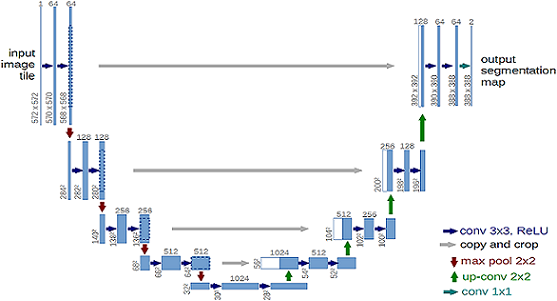 ![unet block.png](<attachment:unet block.png>)
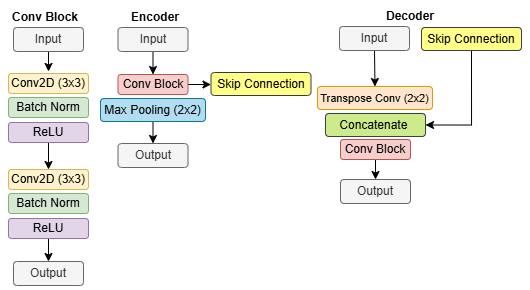

In [161]:
def unet_model(
    img_height: int,
    img_width: int,
    img_channels: int,
    act_dropout: bool = False,
    use_batchnorm: bool = False,
    dropout_rates: dict = {'shallow':0.1, 'mid':0.2, 'deep':0.3},
    n_class:int = 1):
    """
    Args:
        img_height: Height of input images
        img_width: Width of input images
        img_channels: Number of input channels
        act_dropout: Global toggle for dropout (default: False)
        use_batchnorm: Whether to use BatchNormalization (default: False)
        dropout_rates: Dictionary defining dropout rates for different depths
        n_class: Number of output classes (default: 1 for binary segmentation)
    Returns:
        A compiled Keras Model instance
    Example:
        img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape)
         model = unet_model(img_height, img_width, img_channels)
    """

    # Input layer and normalization
    inputs = Input((img_height, img_width, img_channels))
    inputs = Lambda(lambda x: x / 255.0)(inputs)  # Normalize pixel values to [0,1]

    # ======================================= ENCODER (Contracting Path) =======================================
    # Block 1 (Shallow: Lowest Dropout)
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(inputs)
    if use_batchnorm: c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
    if use_batchnorm: c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2 (Shallow: Low Dropout)
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    if use_batchnorm: c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
    if use_batchnorm: c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    if act_dropout: c2 = Dropout(dropout_rates['shallow'])(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3 (Mid-Depth: Moderate Dropout)
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    if use_batchnorm: c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
    if use_batchnorm: c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    if act_dropout: c3 = Dropout(dropout_rates['mid'])(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4 (Mid-Depth: Moderate Dropout)
    c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
    if use_batchnorm: c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
    if use_batchnorm: c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    if act_dropout: c4 = Dropout(dropout_rates['mid'])(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # ======================================= BOTTLENECK (Deepest Layer) =======================================
    c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
    if use_batchnorm: c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
    if use_batchnorm: c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    if act_dropout: c5 = Dropout(dropout_rates['deep'])(c5)  # Maximum dropout

    # ======================================== DECODER (Expansive Path) ========================================
    # Upsample and concatenate with corresponding encoder features
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat1 = concatenate([c4, up1], axis=3)
    c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(concat1)
    if use_batchnorm: c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
    if use_batchnorm: c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    if act_dropout: c6 = Dropout(dropout_rates['mid'])(c6)  # Matches Block 4

    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    concat2 = concatenate([c3, up2], axis=3)
    c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(concat2)
    if use_batchnorm: c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
    if use_batchnorm: c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    if act_dropout: c7 = Dropout(dropout_rates['mid'])(c7)  # Matches Block 3

    up3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    concat3 = concatenate([c2, up3], axis=3)
    c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(concat3)
    if use_batchnorm: c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
    if use_batchnorm: c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    if act_dropout: c8 = Dropout(dropout_rates['shallow'])(c8)  # Matches Block 2

    up4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    concat4 = concatenate([c1, up4], axis=3)
    c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(concat4)
    if use_batchnorm: c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
    if use_batchnorm: c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    # No dropout in final decoder block (shallowest layer)

    # Output layer
    if n_class < 1: raise ValueError("Number of classes must be at least 1")
    act = 'sigmoid' if n_class == 1 else 'softmax'
    c10 = Conv2D(n_class, (1, 1), activation=act)(c9)  # 1x1 conv for output
    
    model = Model(inputs=inputs, outputs=c10)
    return model

In [163]:
list(train_dataset.element_spec[0].shape)

[None, 256, 256, 3]

In [162]:
# Convert any tf.placeholder usage to tf.compat.v1.placeholder
tf.placeholder = tf.compat.v1.placeholder if hasattr(tf, 'placeholder') else None

img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape)

model = unet_model(img_height, img_width, img_channels, 
                   act_dropout=True,
                   use_batchnorm=True,
                   dropout_rates={'shallow':0.1, 'mid':0.2, 'deep':0.3}  # Custom rates
                  )
# model.summary()

ValueError: too many values to unpack (expected 3)

In [82]:
# Hyperparameters
num_epochs = 4
batch_size = 32
learning_rate = 1e-3

train_dataset = train_dataset.shuffle(buffer_size=200, reshuffle_each_iteration=False)
valid_dataset = valid_dataset.shuffle(buffer_size=200, reshuffle_each_iteration=False)

train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

In [83]:
@tf.function  # Use tf.function for faster execution
def dice_coef(y_true, y_pred, smooth = 1e-15):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)    # Avoid flatten operation by using reduce_sum
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

@tf.function
def dice_coef_loss(y_true, y_pred, smooth = 1e-15):
    return 1.0 - dice_coef(y_true, y_pred, smooth)

@tf.function
def iou(y_true, y_pred, smooth=1e-15):
    intersection = tf.reduce_sum(y_true * y_pred) 
    total = tf.reduce_sum(y_true + y_pred)
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

@tf.function
def jaccard_distance(y_true, y_pred):
    # Directly compute IoU without flattening
    return 1.0 - iou(y_true, y_pred)

In [84]:
model.compile(
              optimizer='adam',            # adam, rmsprop
              loss='binary_crossentropy',  # dice_loss, binary_crossentropy, sparse_categorical_crossentropy
              metrics=[
                    #    'accuracy',
                    #    dice_coef, 
                        iou, 
                    #    Recall(), 
                    #    Precision()
                       ],
              run_eagerly=False,  # Set run_eagerly=False for better performance
             )

In [85]:
import os
csv_path = os.path.join("files", "log.csv")

# callbacks = [
           
#              callbacks.TensorBoard(log_dir='logs'),
#             # loss_history(),
#             ]

callbacks = [
            #    callbacks.CSVLogger(csv_path),
               # callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True),
            #    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
            #    CSVLogger(csv_path),
             EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
             ]

In [86]:
results = model.fit(train_dataset,
                    epochs=num_epochs,
                    callbacks=callbacks,
                    validation_data=valid_dataset,
                    shuffle=False,
                   )

# train_steps = len(train_x)//batch_size
# valid_steps = len(valid_x)//batch_size

# if len(train_x) % batch_size != 0:
#    train_steps += 1

# if len(valid_x) % batch_size != 0:
#    valid_steps += 1
# model.fit(
#       train_dataset,
#       epochs=num_epoch,
#       validation_data=valid_dataset,
#       steps_per_epoch=train_steps,
#       validation_steps=valid_steps,
#       callbacks=callbacks
#    )

Epoch 1/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - iou: 0.0010 - loss: 0.4563WARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x00000228BEA15580> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - iou: 0.0010 - loss: 0.4563 - val_iou: 0.0057 - val_loss: 0.0507
Epoch 2/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - iou: 0.0016 - loss: 0.4244 - val_iou: 0.0062 - val_loss: 0.

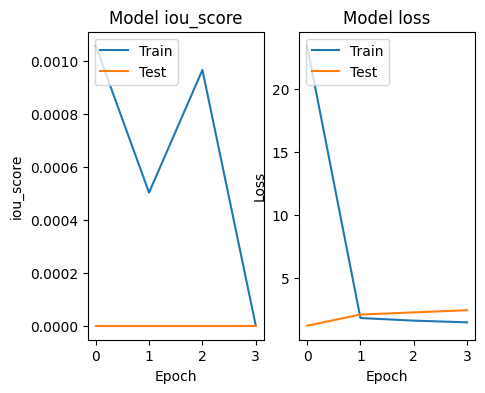

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot training & validation iou_score values
plt.figure(figsize=(5, 4))
plt.subplot(121)
plt.plot(results.history['iou'])
plt.plot(results.history['val_iou'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.tight_layout()

In [ ]:
model_for_visulalization

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

""" Calculating metrics values """
acc_value = accuracy_score(y, y_pred)
f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")

In [ ]:
def conv_block(input, num_filters, kernel_size=(3, 3), activation='relu'):
    conv = Conv2D(num_filters, kernel_size=kernel_size, kernel_initializer='he_normal', padding='same')(input)
    conv = Activation(activation)(conv)
    
    conv = Dropout(0.1)(conv)
    
    conv = Conv2D(num_filters, kernel_size=kernel_size, kernel_initializer='he_normal', padding='same')(conv)
    conv = Activation(activation)(conv)
    
    return conv

def encoder_block(input, num_filters, pool_size=(2, 2)):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D(pool_size)(conv)
    
    return conv, pool

def decoder_block(input, skip_features, num_filters, kernel_size=(2, 2), strides=(2, 2)):
    up = Conv2DTranspose(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(input)
    concat = concatenate([skip_features, up], axis=3)
    d = conv_block(concat, num_filters)
    return d

inputs = Input((img_height, img_width, img_channels))
inputs = Lambda(lambda x: x / 255.0)(inputs)

s1, p1 = encoder_block(inputs, 16)
s2, p2 = encoder_block(p1, 32)
s3, p3 = encoder_block(p2, 64)
s4, p4 = encoder_block(p3, 128)

b1 = conv_block(p4, 256)

d1 = decoder_block(b1, s4, 128)
d2 = decoder_block(d1, s3, 64)
d3 = decoder_block(d2, s1, 32)
d4 = decoder_block(d3, s1, 16)


outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(d4)

In [ ]:
 test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

In [64]:
from tensorflow import keras

class loss_history(keras.callbacks.Callback):
    
    def __init__ (self, x=4):
        self.x = x
        
    def on_epoch_begin(self, epoch, logs={}):
        
        plt.imshow(data[50:][self.x])
        plt.show()
        
        plt.imshow(np.squeeze(masks[50:][self.x]))
        plt.show()
        
        preds_train = self.model.predict(np.expand_dims(data[50:][self.x], axis = 0))
        plt.imshow(np.squeeze(preds_train[0]))
        plt.show()

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[Mean_IOU_Evaluator])

In [62]:
from tensorflow import keras

class loss_history(keras.callbacks.Callback):
    def __init__(self, x=4):
        self.x = x
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        if len(self.losses) > 0 and len(self.losses) % self.x == 0:
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            plt.figure(figsize=(8, 4))
            plt.plot(N, self.losses, label='train_loss')
            plt.plot(N, self.val_losses, label='val_loss')
            plt.title(f'Training Loss [Epoch {len(self.losses)}]')
            plt.xlabel('Epoch #')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()


In [ ]:
# Modify the model.fit() call to avoid the OptionalFromValue error
# The error occurs due to incompatibility with steps_per_execution parameter

# Convert data to numpy arrays if not already
data = np.array(data)
masks = np.array(masks)

# Ensure data types are float32
data = data.astype('float32') 
masks = masks.astype('float32')

# Normalize data if not already done
data = data / 255.0
masks = masks / 255.0

# Update the model compilation to ensure compatibility
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['binary_accuracy'],
             run_eagerly=True) # Add run_eagerly=True to avoid graph execution issues

# Update callbacks to remove TensorBoard which can cause issues
callbacks = [
    callbacks.EarlyStopping(patience=2, monitor='val_loss')
]

# Rerun the fit with updated parameters
results = model.fit(data[50:], masks[50:],
                   epochs=epochs,
                   batch_size=32, # Reduced batch size
                   callbacks=callbacks,
                   validation_split=0.1,
                   verbose=1)


In [ ]:
import pprint
pprint.pprint(results.history)

In [ ]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss') 
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results.history['binary_accuracy'], label='Training Accuracy')
plt.plot(results.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# The reason binary_crossentropy runs faster than dice_coefficient_loss:
# 1. binary_crossentropy is a simpler calculation - just comparing predicted vs actual class
# 2. dice_coefficient requires more complex operations like flattening tensors and matrix multiplication
# 3. binary_crossentropy is highly optimized in Keras/TensorFlow implementations
# 4. dice_coefficient_loss provides better results for imbalanced segmentation tasks despite being slower
# 5. For quick prototyping/testing, binary_crossentropy with accuracy metric is fine
# 6. For production segmentation models, dice_coefficient_loss with IoU/dice metrics is recommended


In [47]:
# idx = random.randint(0, len(X_train))

preds_train = model.predict(data[54:], verbose=1)
preds_val = model.predict(data[56:], verbose=1)
preds_test = model.predict(data[50:52, :], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


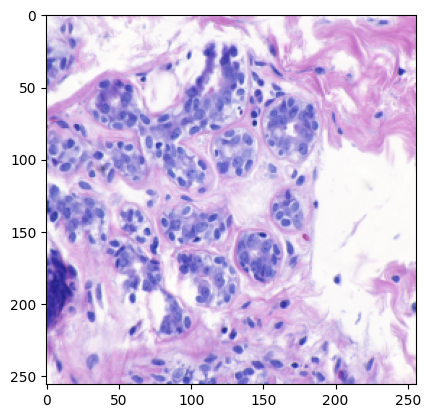

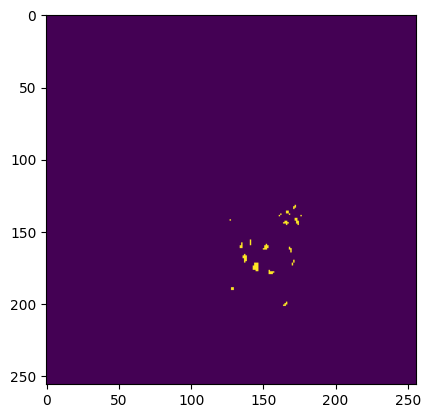

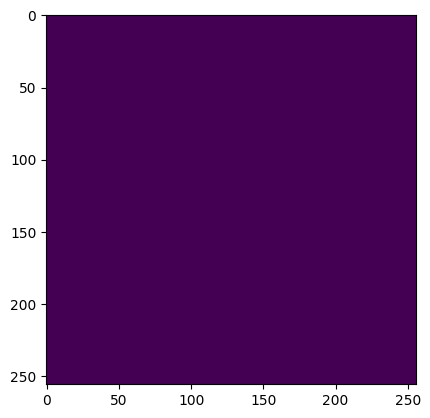

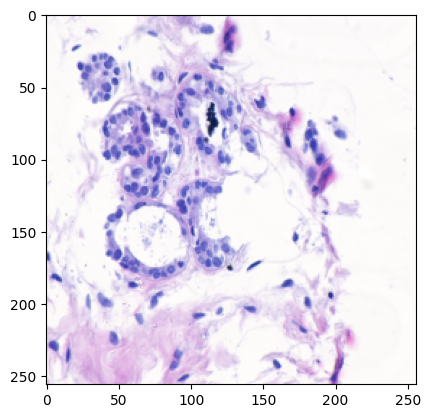

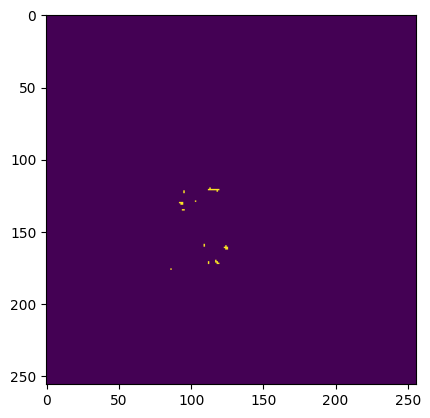

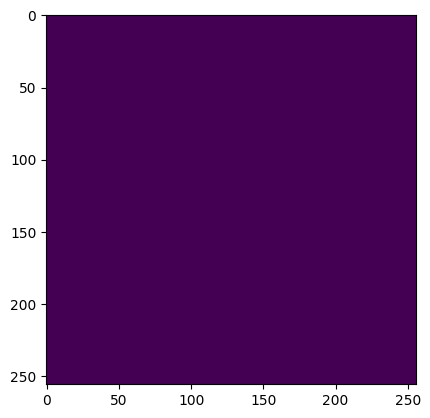

In [48]:
plt.imshow(data[55])
plt.show()
plt.imshow(np.squeeze(masks[55]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[1]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
plt.imshow(data[56:][1])
plt.show()
plt.imshow(np.squeeze(masks[56:][1]))
plt.show()
plt.imshow(np.squeeze(preds_val_t[0]))
plt.show()

In [ ]:
import random
import matplotlib.pyplot as plt
from skimage import io

#  9. U_NET Model Evaluation using Test Samples

preds_train = model.predict(Train_Inputs, verbose=1)
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_test = model.predict(Test_Inputs, verbose=1)
preds_test_t = (preds_test>0.5).astype(np.uint8)
    
# 10. Show Final Results (Segmented Images)

ix = random.randint(0, len(Train_Inputs)-1)

print(ix)

print('Train_Image')
imshow(Train_Inputs[ix])
plt.show()

print('Train_Mask')
imshow(np.squeeze(Train_Masks[ix]))
plt.show()

print('Segmented_Image')
imshow(np.squeeze(preds_train[ix]))
plt.show()


iix = random.randint(0,1)
print(iix)

print('Test_Image')
imshow(Test_Inputs[iix])
plt.show()

print('Test_Mask')
imshow(np.squeeze(Test_Masks[iix]))
plt.show()

print('Segmented_Test_Mask')
imshow(np.squeeze(preds_test[iix]))
plt.show()

Load previously trained Model

In [ ]:
model = load_model('unet.hdf5', 
                   custom_objects={'dice_coefficient_loss': dice_coefficients_loss, 
                                   'iou': iou, 'dice_coefficient': dice_coefficients  } )
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

In [ ]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from metrics import dice_loss, dice_coef
from train import load_dataset
from unet import build_unet

""" Global parameters """
H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

    """ Dataset """
    dataset_path = "/media/nikhil/Seagate Backup Plus Drive/ML_DATASET/brain_tumor_dataset/data"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("results", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")
